In [144]:
from igraph import *

import networkx as nx
from networkx.convert_matrix import _generate_weighted_edges

import scipy as sp
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import requests
import pickle
import json
import copy
import os
import re

from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [64]:
sdg_data_main = pd.read_excel('SDR-2022-database.xlsx')

In [71]:
sdg_data_back = sdg_data_main.drop(sdg_data_main[sdg_data_main['Year'] < 2018].index)
sdg_data_back.head(5)

,Country Code ISO3,Country,Year,Population,Region,Income Group,SDG Index Score,Goal 1 Score,Goal 2 Score,Goal 3 Score,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
18,AFG,Afghanistan,2018,37171922.0,E_Euro_Asia,LIC,51.861687,91.417142,52.326286,38.125429,...,3.968,45.573,100.0,61.029,56.615,24.993,NaN,10.13,100.0,33.127
19,AFG,Afghanistan,2019,38041757.0,E_Euro_Asia,LIC,51.847886,91.417142,51.583286,37.612071,...,3.968,45.573,100.0,62.071,59.538,28.653,NaN,10.13,100.0,33.008
20,AFG,Afghanistan,2020,38928341.0,E_Euro_Asia,LIC,51.860679,91.417142,51.583286,38.087500,...,7.937,45.573,100.0,60.429,53.846,28.653,NaN,10.13,100.0,33.008
21,AFG,Afghanistan,2021,39835428.0,E_Euro_Asia,LIC,52.182782,91.417142,51.583286,38.087500,...,3.968,45.573,100.0,56.871,53.846,28.653,NaN,10.13,100.0,33.008
40,ALB,Albania,2018,2882735.0,E_Euro_Asia,UMIC,72.208848,90.868000,59.869857,82.817143,...,30.423,91.603,100.0,72.157,63.846,42.913,NaN,51.59,100.0,70.129


In [70]:
sdg_data = sdg_data_main.drop(sdg_data_main[sdg_data_main['Year'] >= 2018].index)
sdg_data.head(19)

,Country Code ISO3,Country,Year,Population,Region,Income Group,SDG Index Score,Goal 1 Score,Goal 2 Score,Goal 3 Score,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
0,AFG,Afghanistan,2000,20779957.0,E_Euro_Asia,LIC,44.819087,91.417142,33.883143,20.329857,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
1,AFG,Afghanistan,2001,21606992.0,E_Euro_Asia,LIC,45.109257,91.417142,36.932429,20.445929,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
2,AFG,Afghanistan,2002,22600774.0,E_Euro_Asia,LIC,45.032270,91.417142,35.922000,20.720143,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
3,AFG,Afghanistan,2003,23680871.0,E_Euro_Asia,LIC,45.275423,91.417142,37.142571,20.932000,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
4,AFG,Afghanistan,2004,24726689.0,E_Euro_Asia,LIC,45.530799,91.417142,37.827429,21.980500,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
5,AFG,Afghanistan,2005,25654274.0,E_Euro_Asia,LIC,45.661777,91.417142,39.977000,23.619286,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
6,AFG,Afghanistan,2006,26433058.0,E_Euro_Asia,LIC,45.756497,91.417142,41.212429,23.790643,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
7,AFG,Afghanistan,2007,27100542.0,E_Euro_Asia,LIC,46.036945,91.417142,43.118857,25.500214,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
8,AFG,Afghanistan,2008,27722281.0,E_Euro_Asia,LIC,45.312562,91.417142,43.237857,26.968857,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,0.000,100.0,16.297
9,AFG,Afghanistan,2009,28394806.0,E_Euro_Asia,LIC,45.964674,91.417142,45.346286,29.136000,...,0.000,45.573,100.0,61.329,42.308,26.327,NaN,1.917,100.0,16.297


In [110]:
sdg_pearson_data = sdg_data.corr(method='pearson')
sdg_pearson_data.head()

,Year,Population,SDG Index Score,Goal 1 Score,Goal 2 Score,Goal 3 Score,Goal 4 Score,Goal 5 Score,Goal 6 Score,Goal 7 Score,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
Year,1.000000,0.017998,0.159374,0.042418,0.076124,0.154895,0.113546,0.207232,0.081067,0.115891,...,0.003005,-0.001006,0.000350,-0.029112,-0.000559,0.098923,0.087026,0.043714,-1.827921e-15,0.011789
Population,0.017998,1.000000,-0.016659,-0.047442,0.106383,-0.003366,0.081839,-0.009841,-0.024014,-0.009236,...,-0.043432,0.039994,-0.038684,-0.212861,-0.137148,-0.116182,-0.119423,-0.185255,-3.103673e-03,0.064550
SDG Index Score,0.159374,-0.016659,1.000000,0.861318,0.720178,0.931356,0.871108,0.715143,0.881565,0.809750,...,0.700762,0.821648,-0.406609,0.404472,0.719960,0.698605,0.302189,0.472095,-3.719880e-01,0.767329
Goal 1 Score,0.042418,-0.047442,0.861318,1.000000,0.537421,0.887495,0.784291,0.454163,0.749455,0.752456,...,0.523435,0.824632,-0.320971,0.221546,0.600041,0.536932,0.066877,0.429713,-3.279848e-01,0.548250
Goal 2 Score,0.076124,0.106383,0.720178,0.537421,1.000000,0.656795,0.624993,0.549329,0.652767,0.532754,...,0.587480,0.551385,-0.332100,0.315438,0.554483,0.443335,-0.127954,0.167387,-3.509614e-01,0.667835


In [73]:
sdg_goals = {}
sdg_temp = []
for item in sdg_pearson_data:
    if item.startswith('Goal '):
        sdg_goals[item] = []
        sdg_temp.append(item)
    if item.startswith('n_sdg'):
        n_sdg = item[5:7]
        goal_number = re.sub('[^0-9]', '', n_sdg)
        sdg_goals[f'Goal {goal_number} Score'].append(item)
#print(list(sdg_goals.keys()))

In [112]:
sdg_sub_goals = {}
for k, v in sdg_goals.items():
    for x in v:
        sdg_sub_goals.setdefault(x,[]).append(k)
#print(list(sdg_sub_goals.keys()))

In [118]:
sdg_bipart_pearson = sdg_pearson_data[list(sdg_sub_goals.keys())]
sdg_bipart_pearson = sdg_bipart_pearson.loc[list(sdg_goals.keys())]
sdg_bipart_pearson.head()

,n_sdg1_wpc,n_sdg1_320pov,n_sdg2_undernsh,n_sdg2_stunting,n_sdg2_wasting,n_sdg2_obesity,n_sdg2_trophic,n_sdg2_crlyld,n_sdg2_snmi,n_sdg2_pestexp,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
Goal 1 Score,0.949917,0.978330,0.745980,0.815999,0.568709,-0.669814,-0.733368,0.562693,0.288466,-0.147493,...,0.523435,0.824632,-0.320971,0.221546,0.600041,0.536932,0.066877,0.429713,-0.327985,0.548250
Goal 2 Score,0.488661,0.579992,0.727092,0.689401,0.688965,-0.337381,-0.322784,0.704971,0.542452,0.218537,...,0.587480,0.551385,-0.332100,0.315438,0.554483,0.443335,-0.127954,0.167387,-0.350961,0.667835
Goal 3 Score,0.838892,0.906341,0.795313,0.866149,0.660882,-0.657419,-0.742575,0.681479,0.307957,-0.166653,...,0.669645,0.836854,-0.393827,0.294416,0.664003,0.621122,0.434453,0.336407,-0.369322,0.661284
Goal 4 Score,0.779708,0.811087,0.697229,0.770943,0.653278,-0.562665,-0.658379,0.612960,0.272141,-0.122942,...,0.561290,0.775553,-0.353832,0.276130,0.608792,0.550756,0.002156,0.318261,-0.329635,0.647183
Goal 5 Score,0.440576,0.567247,0.492219,0.576468,0.662457,-0.361548,-0.519354,0.451631,0.318699,-0.159010,...,0.568159,0.593138,-0.362947,0.436586,0.580409,0.623085,0.348992,0.229350,-0.280855,0.612628


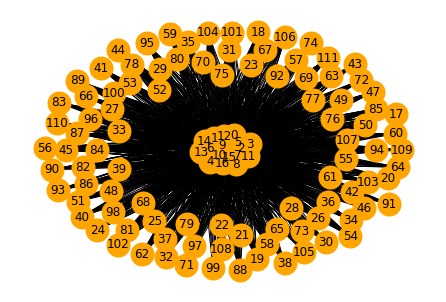

In [145]:
#sdg_goals_names = list(sdg_goals.keys()) + list(sdg_sub_goals.keys())
#values = sdg_bipart_pearson.values
A = sp.sparse.csr_matrix(sdg_bipart_pearson.values>0)

graph_sdg_b = nx.empty_graph(0)
n, m = A.shape

graph_sdg_b.add_nodes_from(range(n), bipartite=0)
graph_sdg_b.add_nodes_from(range(n, n+m), bipartite=1)
triples = ((u, n + v, d) for (u, v, d) in _generate_weighted_edges(A))
graph_sdg_b.add_weighted_edges_from(triples)

nx.draw(graph_sdg_b, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_b, k=0.15, weight='value', iterations=50))

In [132]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(["a", "b", "c"], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])
bottom_nodes, top_nodes = nx.bipartite.sets(B)
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes
print(nx.is_bipartite())
nx.draw(B, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(B, k=0.15, weight='value', iterations=50))

True


AttributeError: 'Graph' object has no attribute 'color'

In [75]:
sdg_sub_pearson = sdg_pearson_data[list(sdg_sub_goals.keys())]
sdg_sub_pearson = sdg_sub_pearson.loc[list(sdg_sub_goals.keys())]
sdg_sub_pearson.head()

,n_sdg1_wpc,n_sdg1_320pov,n_sdg2_undernsh,n_sdg2_stunting,n_sdg2_wasting,n_sdg2_obesity,n_sdg2_trophic,n_sdg2_crlyld,n_sdg2_snmi,n_sdg2_pestexp,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
n_sdg1_wpc,1.000000,0.864629,0.752471,0.755125,0.492921,-0.617749,-0.692117,0.537564,0.248909,-0.166958,...,0.434526,0.780661,-0.273767,0.175093,0.491202,0.459504,0.281510,0.376924,-0.270911,0.525402
n_sdg1_320pov,0.864629,1.000000,0.755636,0.868565,0.655830,-0.696232,-0.744923,0.569422,0.311570,-0.146963,...,0.585255,0.822009,-0.379319,0.335383,0.658344,0.595561,0.325338,0.462520,-0.370700,0.620244
n_sdg2_undernsh,0.752471,0.755636,1.000000,0.754495,0.532570,-0.545436,-0.625359,0.565681,0.341642,-0.065769,...,0.541163,0.706839,-0.320845,0.246743,0.507741,0.498471,0.080920,0.308826,-0.267054,0.595109
n_sdg2_stunting,0.755125,0.868565,0.754495,1.000000,0.703085,-0.692266,-0.710542,0.591598,0.271444,-0.017066,...,0.666576,0.777166,-0.389404,0.380895,0.728005,0.620123,-0.036823,0.491437,-0.403382,0.594604
n_sdg2_wasting,0.492921,0.655830,0.532570,0.703085,1.000000,-0.572008,-0.460249,0.432890,0.255128,-0.083309,...,0.575546,0.607448,-0.336229,0.459909,0.622268,0.545660,-0.071793,0.362240,-0.346342,0.589612


In [76]:
sdg_pearson = sdg_pearson_data[list(sdg_goals.keys())]
sdg_pearson = sdg_pearson.loc[list(sdg_goals.keys())]
sdg_pearson.head()

,Goal 1 Score,Goal 2 Score,Goal 3 Score,Goal 4 Score,Goal 5 Score,Goal 6 Score,Goal 7 Score,Goal 8 Score,Goal 9 Score,Goal 10 Score,Goal 11 Score,Goal 12 Score,Goal 13 Score,Goal 14 Score,Goal 15 Score,Goal 16 Score,Goal 17 Score
Goal 1 Score,1.000000,0.537421,0.887495,0.784291,0.454163,0.749455,0.752456,0.534218,0.597812,0.464367,0.720686,-0.669936,-0.578980,-0.255324,0.029609,0.661678,0.416940
Goal 2 Score,0.537421,1.000000,0.656795,0.624993,0.549329,0.652767,0.532754,0.637984,0.643947,0.270246,0.549221,-0.544744,-0.485195,-0.113936,0.158775,0.607300,0.301736
Goal 3 Score,0.887495,0.656795,1.000000,0.862728,0.604188,0.817959,0.791085,0.685483,0.740929,0.418346,0.800567,-0.753577,-0.646351,-0.237278,0.057181,0.775286,0.448879
Goal 4 Score,0.784291,0.624993,0.862728,1.000000,0.684831,0.743789,0.744999,0.647507,0.632287,0.267516,0.767259,-0.666911,-0.560665,-0.208791,0.038102,0.640908,0.422162
Goal 5 Score,0.454163,0.549329,0.604188,0.684831,1.000000,0.654283,0.544278,0.619587,0.613087,0.072556,0.629669,-0.590898,-0.430327,-0.014142,0.218705,0.519789,0.458469


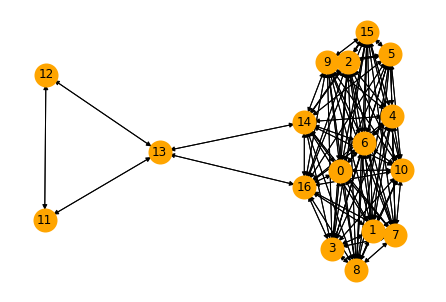

In [102]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph_sdg_p = Graph.Weighted_Adjacency((values>0).tolist())
graph_sdg_p = graph_sdg_p.simplify()
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph_sdg_p = graph_sdg_p.to_networkx()

nx.draw(graph_sdg_p, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_p, k=0.15, weight='value', iterations=50))

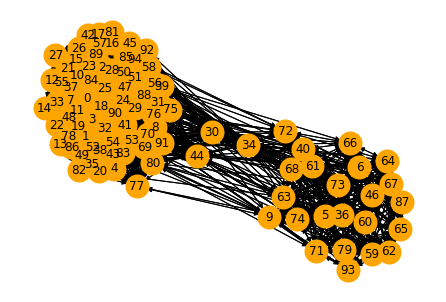

In [103]:
sdg_sub_goals_names = list(sdg_sub_goals.keys())
values = sdg_sub_pearson.values
graph_sdg_sub_p = Graph.Weighted_Adjacency((values>0).tolist())
graph_sdg_sub_p = graph_sdg_sub_p.simplify()
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph_sdg_sub_p = graph_sdg_sub_p.to_networkx()

nx.draw(graph_sdg_sub_p, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_sub_p, k=0.15, weight='value', iterations=50))

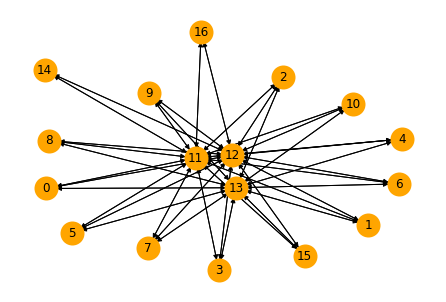

In [97]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph_sdg_n = Graph.Weighted_Adjacency((values<0).tolist())
graph_sdg_n = graph_sdg_n.simplify()
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph_sdg_n = graph_sdg_n.to_networkx()

nx.draw(graph_sdg_n, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_n, k=0.15, weight='value', iterations=50))

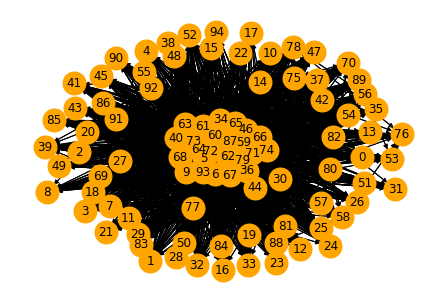

In [105]:
sdg_sub_goals_names = list(sdg_sub_goals.keys())
values = sdg_sub_pearson.values
graph_sdg_sub_n = Graph.Weighted_Adjacency((values<0).tolist())
graph_sdg_sub_n = graph_sdg_sub_n.simplify()
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph_sdg_sub_n = graph_sdg_sub_n.to_networkx()

nx.draw(graph_sdg_sub_n, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph_sdg_sub_n, k=0.15, weight='value', iterations=50))

In [ ]:
for target_1 in sdg_goals_names:
    figure, ax = plt.subplots(figsize=(20,10))
    goal_name_1 = target_1
    ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_1, order=1, ax = ax, scatter=False)
    for target_2 in sdg_goals_names:
        if target_2 != target_1:
            goal_name_2 = target_2
            ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_2, order=1, ax = ax, scatter=False)

In [ ]:
for target_1 in sdg_sub_goals_names:
    figure, ax = plt.subplots(figsize=(20,10))
    goal_name_1 = target_1
    ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_1, order=1, ax = ax, scatter=False)
    for target_2 in sdg_sub_goals_names:
        if target_2 != target_1:
            goal_name_2 = target_2
            ax = sns.regplot(data=sdg_data, x=goal_name_1, y=goal_name_2, order=1, ax = ax, scatter=False)

In [221]:
political_blogs = Graph.Read(
    f="polblogs.gml", format="gml"
    )
political_blogs_data = f'{political_blogs.summary()[7:].replace("-","").strip()[:-51]} {len(political_blogs.clusters(mode="strong"))} {len(political_blogs.clusters(mode="weak"))} {political_blogs.maxdegree()} {political_blogs.average_path_length()} {political_blogs.diameter()} {political_blogs.transitivity_avglocal_undirected()} {political_blogs.transitivity_undirected()}'
political_blogs_data = political_blogs_data.split()
data_requests = ['type', 'n', 'm', 'c_strong', 'c_weak', 'd', 'l', 'L', 'cc_l', 'cc_g']
counter = 0
for data in political_blogs_data:
    print(f'{data_requests[counter]}: {data}')
    counter += 1

type: D
n: 1490
m: 19090
c_strong: 688
c_weak: 268
d: 468
l: 3.3901837252152363
L: 9
cc_l: 0.3600286522101197
cc_g: 0.2259585173589758


N = 1490, mean +- sd: 25.6242 +- 42.9418
Each * represents 4 items
[  0,   1): ****************************************************************** (266)
[  1,   2): ******************************** (129)
[  2,   3): *********************** (95)
[  3,   4): ******************** (80)
[  4,   5): ************* (53)
[  5,   6): ********** (40)
[  6,   7): ********** (41)
[  7,   8): ******** (34)
[  8,   9): ******* (29)
[  9,  10): **** (16)
[ 10,  11): ***** (21)
[ 11,  12): ***** (21)
[ 12,  13): *** (14)
[ 13,  14): ***** (22)
[ 14,  15): ****** (25)
[ 15,  16): ******* (28)
[ 16,  17): **** (16)
[ 17,  18): ***** (23)
[ 18,  19): ***** (20)
[ 19,  20): **** (16)
[ 20,  21): *** (13)
[ 21,  22): **** (16)
[ 22,  23): **** (16)
[ 23,  24): ** (11)
[ 24,  25): ** (8)
[ 25,  26): * (7)
[ 26,  27): ** (8)
[ 27,  28): *** (12)
[ 28,  29): ** (8)
[ 29,  30): * (5)
[ 30,  31): ** (10)
[ 31,  32): * (6)
[ 32,  33): * (7)
[ 33,  34): *** (12)
[ 34,  35): ** (10)
[ 35,  36): * (7)
[ 36,  37): ** 

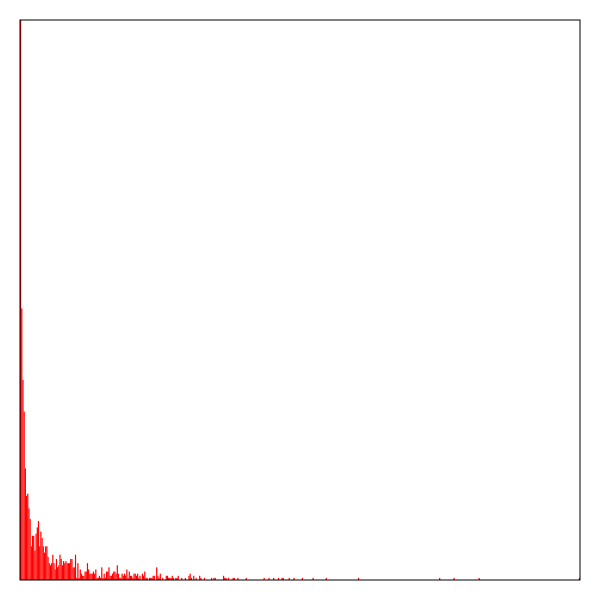

In [222]:
print(political_blogs.degree_distribution())
plot(political_blogs.degree_distribution())

N = 981248, mean +- sd: 3.3902 +- 1.1302
Each * represents 5901 items
[ 1,  2): *** (19022)
[ 2,  3): ******************************** (193830)
[ 3,  4): *********************************************************** (348198)
[ 4,  5): ********************************************** (275702)
[ 5,  6): ****************** (107394)
[ 6,  7): **** (25602)
[ 7,  8): * (10092)
[ 8,  9):  (1371)
[ 9, 10):  (37)


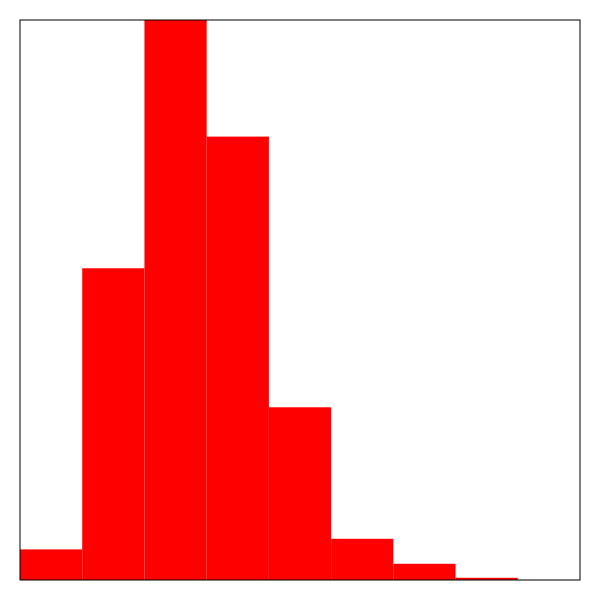

In [223]:
print(political_blogs.path_length_hist())
plot(political_blogs.path_length_hist())